## Setup

Load libraries:

In [1]:
import sys
sys.path.append('../') 

In [3]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt

from utils.plotting_utils import plot_var, plot_results
from utils.validation_utils import validate_predictions
from sklearn.metrics import mean_squared_error, r2_score

## Load Data

* In-situ Data

In [4]:
insitu_data = pd.read_csv('../data/insitu_feb_08.csv')

insitu_data.info()
insitu_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747 entries, 0 to 1746
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   easting              1747 non-null   float64
 1   northing             1747 non-null   float64
 2   observed_snow_depth  1747 non-null   float64
dtypes: float64(3)
memory usage: 41.1 KB


,easting,northing,observed_snow_depth
0,251862.3,4331429.2,1.33
1,251862.3,4331426.2,1.58
2,251862.3,4331423.2,1.51
3,251862.3,4331420.3,1.34
4,251862.3,4331417.3,1.48


* Predicted Snow Depth (XGBoost) and Lidar Snow Depth

In [5]:
xgboost_train_pred = pd.read_csv('../results/XGBoost/AllCombined/all/train_predictions.csv')
xgboost_train_pred.info()
xgboost_train_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981587 entries, 0 to 5981586
Data columns (total 1 columns):
 #   Column           Dtype  
---  ------           -----  
 0   snow_depth_pred  float64
dtypes: float64(1)
memory usage: 45.6 MB


,snow_depth_pred
0,1.205211
1,0.790902
2,1.004301
3,0.933287
4,1.500561


In [6]:
xgboost_test_pred = pd.read_csv('../results/XGBoost/AllCombined/all/test_predictions.csv')
xgboost_test_pred.info()
xgboost_test_pred.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664621 entries, 0 to 664620
Data columns (total 1 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   snow_depth_pred  664621 non-null  float64
dtypes: float64(1)
memory usage: 5.1 MB


,snow_depth_pred
0,1.317406
1,1.455900
2,1.320729
3,0.884155
4,1.023602


In [7]:
with open('../data/full_splits.pkl', 'rb') as f:
    full_splits = pickle.load(f)

In [11]:
all_test_pred=(
    full_splits['X_test'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_test'].reset_index(drop=True),
        snow_depth_pred=xgboost_test_pred['snow_depth_pred']
    )
)

all_test_pred.loc[all_test_pred.snow_depth_pred < 0, 'snow_depth_pred'] = 0

all_train_pred=(
    full_splits['X_temp'][['idx','easting', 'northing']]
    .reset_index(drop=True)
    .assign(
        snow_depth=full_splits['y_temp'].reset_index(drop=True),
        snow_depth_pred=xgboost_train_pred['snow_depth_pred']
    )
)

all_train_pred.loc[all_train_pred.snow_depth_pred < 0, 'snow_depth_pred'] = 0

xgboost_pred=pd.concat([all_train_pred, all_test_pred], axis=0)
xgboost_pred.head()

,idx,easting,northing,snow_depth,snow_depth_pred
0,7105617,228981.856936,4.328396e+06,1.205490,1.205211
1,707495,222696.352076,4.322638e+06,0.792893,0.790902
2,7362767,220509.176400,4.328630e+06,1.004318,1.004301
3,4097011,222261.317134,4.325689e+06,0.933029,0.933287
4,3892236,227874.768013,4.325503e+06,1.500168,1.500561


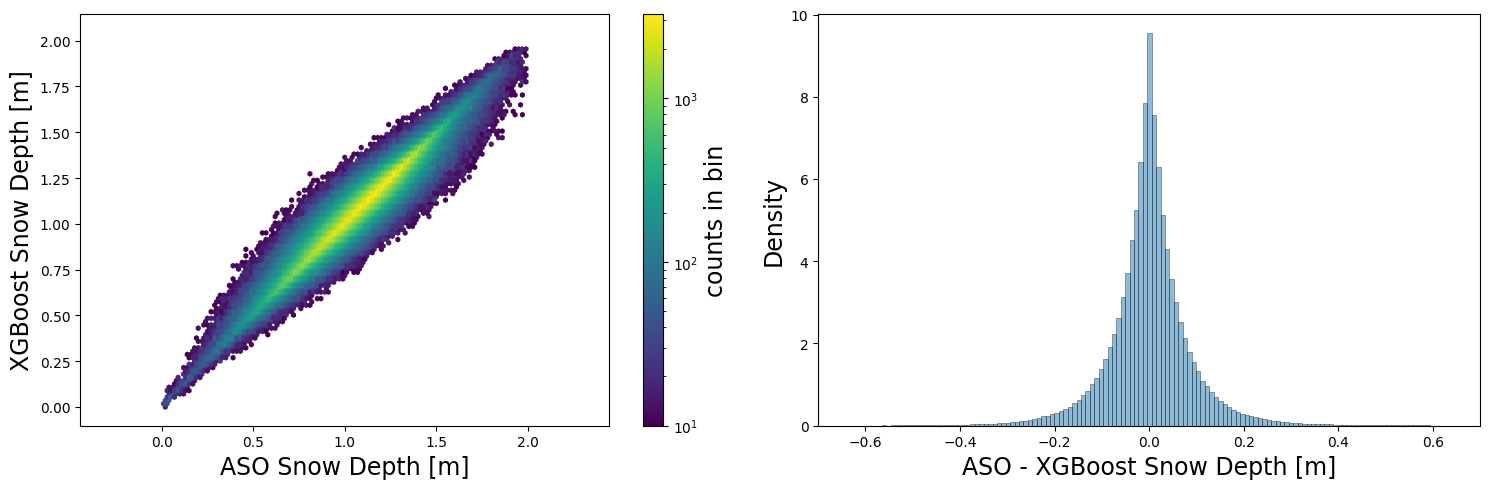

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

hb = plt.hexbin(all_test_pred.snow_depth, all_test_pred.snow_depth_pred, gridsize=100, cmap='viridis', bins='log', mincnt=10)
plt.axis('equal')
plt.xlabel('ASO Snow Depth [m]', fontsize=17)
plt.ylabel('XGBoost Snow Depth [m]', fontsize=17)
cb = plt.colorbar(hb)
cb.set_label('counts in bin', fontsize=17)


plt.subplot(1,2,2)

depth_diff=all_test_pred.snow_depth - all_test_pred.snow_depth_pred
plt.hist(depth_diff, bins=250, alpha=0.5, density=True, edgecolor='black', linewidth=0.5)
plt.xlim(-0.7, 0.7)
plt.ylabel('Density', fontsize=17)
plt.xlabel('ASO - XGBoost Snow Depth [m]', fontsize=17)

plt.tight_layout()
plt.savefig('../plots/ASO_vs_XGBoost.png', dpi=300)
plt.show()

## Validation

In [9]:
insitu_vs_xgboost=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth_pred',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

insitu_vs_lidar=validate_predictions(
    predictions=xgboost_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

insitu_vs_xgboost_test=validate_predictions(
    predictions=all_test_pred,
    ground_truth=insitu_data,
    pred_col='snow_depth_pred',
    gt_col='observed_snow_depth',
    buffer_distance=3
)

In [10]:
lidar_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_lidar['observed_snow_depth'],
    y_pred=insitu_vs_lidar['snow_depth'],
    squared=False
)

lidar_insitu_r2=r2_score(
    y_true=insitu_vs_lidar['observed_snow_depth'],
    y_pred=insitu_vs_lidar['snow_depth']
)

xgboost_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_xgboost['observed_snow_depth'],
    y_pred=insitu_vs_xgboost['snow_depth_pred'],
    squared=False
)

xgboost_insitu_r2=r2_score(
    y_true=insitu_vs_xgboost['observed_snow_depth'],
    y_pred=insitu_vs_xgboost['snow_depth_pred']
)

xgboost_test_insitu_rmse=mean_squared_error(
    y_true=insitu_vs_xgboost_test['observed_snow_depth'],
    y_pred=insitu_vs_xgboost_test['snow_depth_pred'],
    squared=False
)

xgboost_test_insitu_r2=r2_score(
    y_true=insitu_vs_xgboost_test['observed_snow_depth'],
    y_pred=insitu_vs_xgboost_test['snow_depth_pred']
)

print("RMSE:")
print("=====")
print(f'Lidar vs insitu data: {lidar_insitu_rmse*100:.3f} [cm]')
print(f'XGBoost vs insitu data: {xgboost_insitu_rmse*100:.3f} [cm]')
print(f'XGBoost (test) vs insitu : {xgboost_test_insitu_rmse*100:.3f} [cm]')

print("")
print("R^2:")
print("===")
print(f'Lidar vs insitu data: {lidar_insitu_r2:.3f}')
print(f'XGBoost vs insitu data: {xgboost_insitu_r2:.3f}')
print(f'XGBoost (test) vs insitu : {xgboost_test_insitu_r2:.3f}')

RMSE:
=====
Lidar vs insitu data: 15.853 [cm]
XGBoost vs insitu data: 16.020 [cm]
XGBoost (test) vs insitu : 19.705 [cm]

R^2:
===
Lidar vs insitu data: 0.332
XGBoost vs insitu data: 0.318
XGBoost (test) vs insitu : 0.095


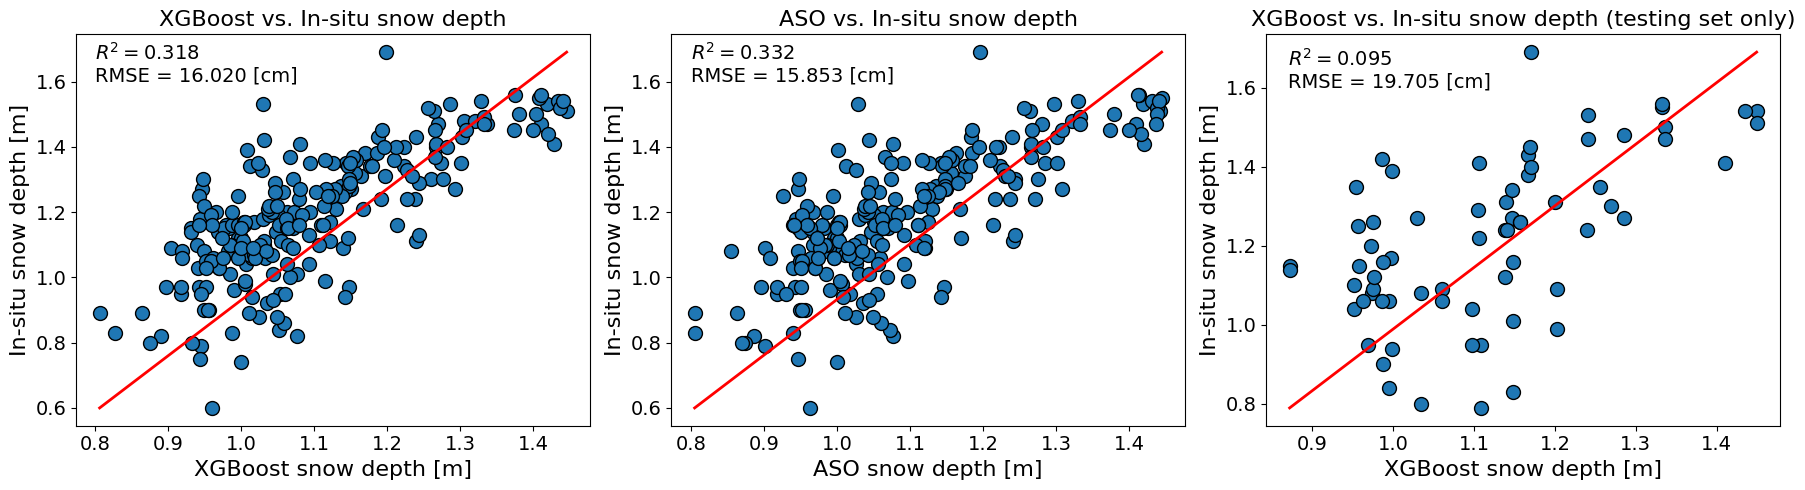

In [12]:
# Prepare the figure
plt.figure(figsize=(18, 5))

# Subplot 1
#predictions1 = train_and_predict(insitu_vs_xgboost['snow_depth_pred'], insitu_vs_xgboost['observed_snow_depth'])
ax1 = plt.subplot(1, 3, 1)
plot_results(ax1, insitu_vs_xgboost['snow_depth_pred'], insitu_vs_xgboost['observed_snow_depth'],
             'XGBoost vs. In-situ snow depth', 'XGBoost snow depth [m]', 'In-situ snow depth [m]', xgboost_insitu_r2, xgboost_insitu_rmse)

# Subplot 2
ax2 = plt.subplot(1, 3, 2)
plot_results(ax2, insitu_vs_lidar['snow_depth'], insitu_vs_lidar['observed_snow_depth'],
             'ASO vs. In-situ snow depth', 'ASO snow depth [m]', 'In-situ snow depth [m]', lidar_insitu_r2, lidar_insitu_rmse)

# Subplot 3
ax3 = plt.subplot(1, 3, 3)
plot_results(ax3, insitu_vs_xgboost_test['snow_depth_pred'], insitu_vs_xgboost_test['observed_snow_depth'],
             'XGBoost vs. In-situ snow depth (testing set only)', 'XGBoost snow depth [m]', 'In-situ snow depth [m]', xgboost_test_insitu_r2, xgboost_test_insitu_rmse, pos1=0.87)

plt.tight_layout()
plt.savefig('../plots/validation_plots.png', dpi=300)
plt.show()

## Spatial plots

In [14]:
null_values_df=(
    pd.read_csv('../data/null_rows.csv')
    .assign(snow_depth_pred=lambda x: x.snow_depth)
)

full_data=(
    pd.concat([xgboost_pred, null_values_df], axis=0)
    .reset_index(drop=True)
    .sort_values(by='idx')
    .assign(snow_depth_diff=lambda x: x.snow_depth - x.snow_depth_pred)
)

In [15]:
shape=(2333, 3333)
true_depth=full_data.snow_depth.values.reshape(shape)
predicted_depth=full_data.snow_depth_pred.values.reshape(shape)
depth_error=full_data.snow_depth_diff.values.reshape(shape)

In [16]:
insitu_data_full = pd.read_csv('../data/all_insitu.csv')
new_insitu = insitu_data[insitu_data.northing.between(full_data.northing.min(), full_data.northing.max()) & insitu_data.easting.between(full_data.easting.min(), full_data.easting.max())]
new_insitu_full = insitu_data_full[insitu_data_full.northing.between(full_data.northing.min(), full_data.northing.max()) & insitu_data_full.easting.between(full_data.easting.min(), full_data.easting.max())]
new_insitu=new_insitu.sample(150)
new_insitu_full=new_insitu_full.sample(1000)

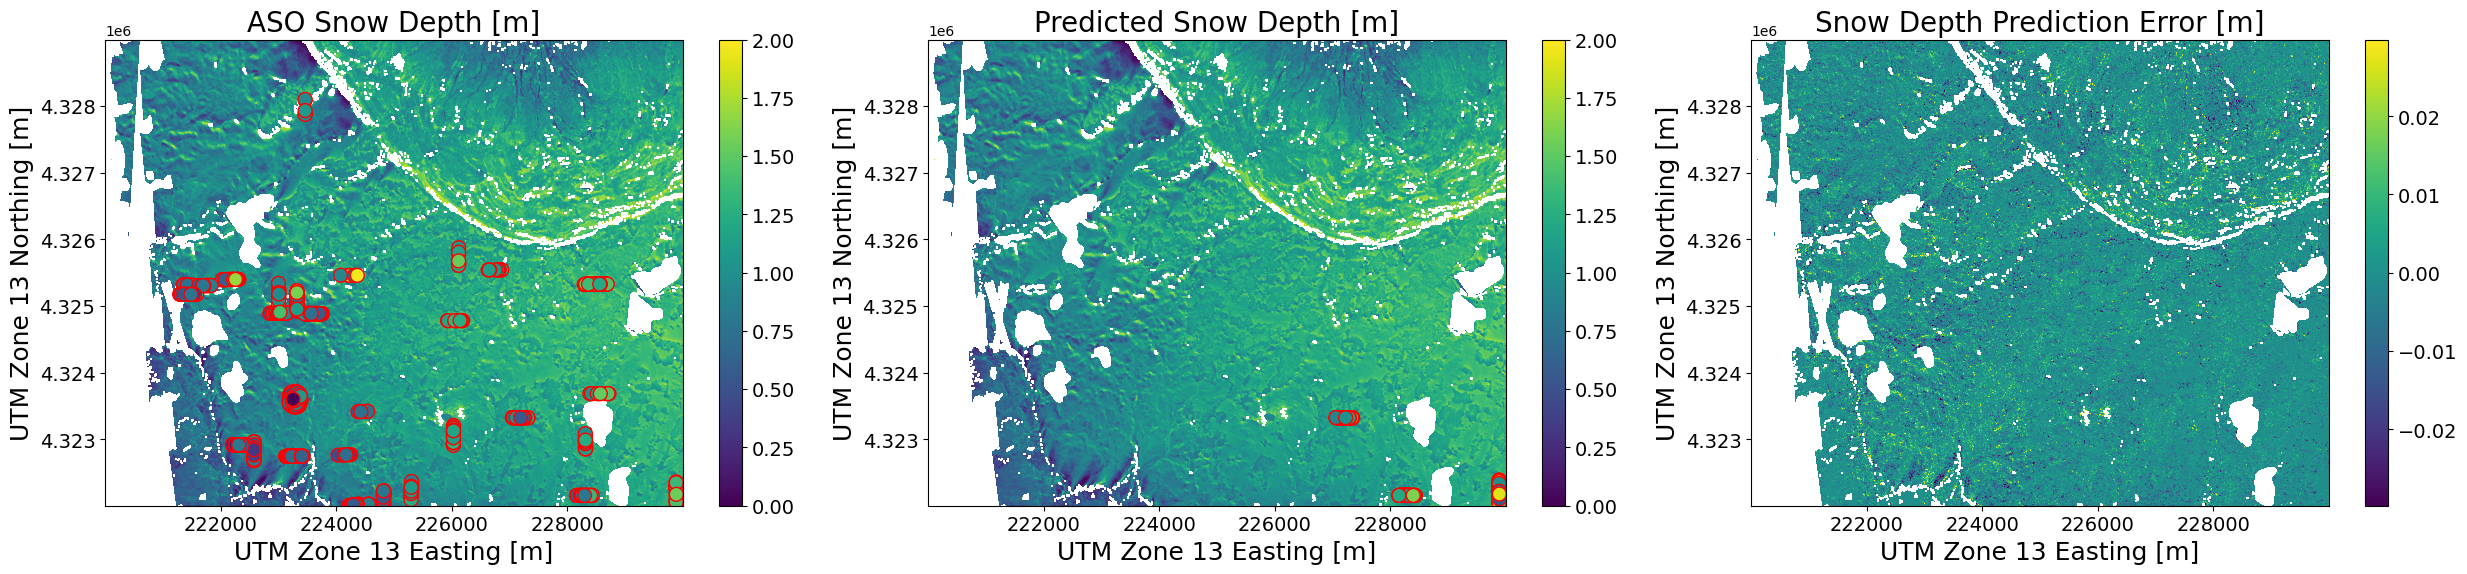

In [17]:
stdev=full_data.snow_depth_diff.std()
avg=full_data.snow_depth_diff.mean()

moe1 = avg - 1*stdev

moe2 = avg + 1*stdev

plt.figure(figsize=(25,6))
plt.subplot(1,3,1)

plot_var(
    variable=true_depth, 
    var_name='ASO Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)
plt.scatter(new_insitu_full.easting, new_insitu_full.northing, s=100, c=new_insitu_full.observed_snow_depth, alpha=1, edgecolors='red')

plt.subplot(1,3,2)

plot_var(
    variable=predicted_depth, 
    var_name='Predicted Snow Depth [m]', 
    clims=(0, 2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)
plt.scatter(new_insitu.easting, new_insitu.northing, s=100, c=new_insitu.observed_snow_depth, alpha=1, edgecolors='red')

plt.subplot(1,3,3)

plot_var(
    variable=depth_error, 
    var_name='Snow Depth Prediction Error [m]', 
    clims=(moe1, moe2), 
    pi_cbar=False, 
    easting=full_data.easting, 
    northing=full_data.northing,
)

plt.tight_layout()